In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd 'drive/My Drive/Thesis'

Mounted at /content/drive/
/content/drive/My Drive/Thesis


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
# import uniform distribution
from scipy.stats import uniform
from scipy.stats import binom
import scipy.special as sc
from scipy.optimize import fsolve
from scipy.stats import norm
import time
np.random.seed(5)

In [3]:
def auction_exp(data_auction, p):
    """Train a normalizing flow model with maximum likelihood.

    Args:
        model: normalizing flow model. Flow or StackedFlows
        dataset: dataset containing data to fit. Dataset
        batch_size: number of samples per batch. int
        max_epochs: number of training epochs. int
        frequency: frequency for plotting density visualization. int
        
    Return:
        model: trained model. Flow or StackedFlows
        losses: loss evolution during training. list of floats
    """
    revenue = 0
    for bid in data_auction:
        if bid >= p:
          #change the bidder with price p
          revenue += p
    
    revenue = revenue/len(data_auction)
    return revenue

In [4]:
def rejection_sampling(pi1, pi2, N):

    # def f(x):
    #   return [x[0] * (1 + np.log(x[1]/x[0])) - u,
    #           x[0] *(2*x[1]-x[0]) - u**2 - sigma**2]


    # root = fsolve(f, [ini1,ini2])

    # pi1 = min(root)
    # pi2 = max(root)
    #using rejection sampling, get N random price samples
    n = 0
    #A =(pi2/pi1-1)*(pi2-pi1)/don
    don = pi2*np.log(pi2/pi1) - (pi2-pi1)
    env =(pi2/pi1-1)/don
    rej_sample =[]
    while(n <= N):
        x = uniform.rvs(loc=pi1, scale=pi2-pi1)
        a = (pi2/x-1)/don/env
        u1 = uniform.rvs()
        if (u1 <= a):
            rej_sample.append(x)
            n += 1
    return rej_sample

In [20]:
#uniform distribution, changing sigma for unifrom distribution while keep u fixed

#Azard and Micali k(r) function
def k_r(x):
    return (0.5*(3*x +x**3) -1/r_m)
#Equavelent funtion like A&M, but using consistent notation with Robust paper
def rho_tilde(x):
    return ((x-1)**3)/(x**2) - (27/4)*r_m**2 
#Deterministic DAPX from the Robust paper
def rho_D(x):
    return ((x-1)**3)/((2*x-1)**2) - r_m**2  

def log_lottery(x):
    return (x * (1 + np.log(cons_m/(x**2) + 1) - np.log(2)) -u_m )


#theorem 2 
def random_rho(x):
    return ((2*np.exp(x-1)-1)-(x**2)*r_m**2 - x**2)


tic = time.clock()
sigma_list = []
u_m_list=[]
r_list =[]
reserve_p_list = []
p_d_list = []
sigma_list = []
u_m_list =[]
rho_list =[]
r_rho_list=[]
rev_A_list = []
rev_A1_list=[]
DAPX = []
DAPX_A1 = []
DAPX_A2 = []
#bundling price for Azar and Micali mechanism
p_AM = []
p_AM_list = []
p_A1_list = []
rev_A2_list = []
p_A2_list = []
APX_uniform_list = []
APX_rev_list = []
step = np.arange(0, 5, 0.1)
#step = np.arange(0, 17.5, 0.35)
n = 100000
m = 5
k = 30
for i in step:
    b = 10 - i
    a = 10 -b
    u = (a+b)/2
    sigma = np.sqrt((b-a)**2/12)
    r_list.append(sigma/u)
    bid_uniform = []
    bid_uniform = uniform.rvs(loc=a, scale=b-a,size=n)
    #Compute expected revenue for A1:selling separately with optimal reserve price
    if (b/2 >= a):
        rev_A1 = m*auction_exp(bid_uniform,b/2)
        rev_A1_list.append(rev_A1)
        p_A1_list.append(b/2)
    else:
        rev_A1 = m*auction_exp(bid_uniform,a)
        rev_A1_list.append(rev_A1)
        p_A1_list.append(a)

    
    #Generate Y randome variables, where Y = sum (X1,X2,...,Xm)
    j = 0
    bundlebid_uniform = []
    while j < n:
        bid = uniform.rvs(loc=a, scale=b-a,size=m)
        bundlebid_uniform.append(sum(bid))
        j += 1

    #Compute the mean and standard deviation for the convolution of the uniform distributions    
    u_m = m*u
    u_m_list.append(u_m)
    sigma_m = np.sqrt(m)*sigma
    r_m = sigma_m/u_m
#     p_d = fsolve(F, [u_m])
#     print(F(p_d))
#     p_reserve = p_d*u_m/(2*p_d-1)

                
##### This is direct implementation for Azard and Micali mechanism
#     k = fsolve(k_r, [u])
#     print(k_r(k))
#     p.append(u - k*sigma)

    # This is equavelent to the Azar and Micali mechanism, we use paper's notation
    # Here we obtain the expected revenue for Azard and Micali mechanism
    rho = fsolve(rho_tilde, [u_m])
    rho_list.append(rho[0])
    p_AM = u_m*(rho+2)/(3*rho)
    p_AM_list.append(p_AM)
    print(rho_tilde(rho))
    rev_A = auction_exp(bundlebid_uniform,p_AM)
    rev_A_list.append(rev_A[0])
    DAPX.append(u_m/rev_A[0])
    DAPX_A1.append(rev_A1/rev_A)
    # Here we obtain the expected revenue for A2: selling it grand bundle with optimal reserve price
    # We use discretization here
    prices = np.linspace(p_AM,u_m,k+2)[1:] #we want k discrete values between p_AM and u_m, here we also include u_m to have a look
    rev = []
    for p in prices:
        rev.append(auction_exp(bundlebid_uniform,p))
    #Store the highest expected revenue and corresponding reserve price  
    rev_A2 = max(rev)
    rev_A2_list.append(rev_A2[0])    
    p_A2_list.append(prices[np.argmax(rev)])
    DAPX_A2.append(rev_A2/rev_A)
    
    #compute the APX using full-bundle log lottery randomization 
    cons_m = u_m**2 + sigma_m**2
    pi1 = fsolve(log_lottery, [u_m-0.2])
    pi2 = 0.5*(cons_m/pi1 +pi1)
    print(log_lottery(pi1))
    rej_sample = []
    rej_sample = rejection_sampling(pi1,pi2,10000)
    rexp_revenue_list =[]
    for rp_reserve in rej_sample:
        rexp_revenue_list.append(auction_exp(bundlebid_uniform,rp_reserve))
  
    APX_rev = np.average(rexp_revenue_list)
    APX_rev_list.append(APX_rev)
    APX_uniform_list.append(u_m/APX_rev)
    #compute the APX using full-bundle log lottery randomization 
    r_rho = fsolve(random_rho, [u])
    r_rho_list.append(r_rho[0])
    print(random_rho(r_rho))
    
    
    
toc = time.clock()
print('time: ' + str(toc-tic))    
# print('the expected revenue for Azard and Micali: ' + str(rev_A))    
# print('the expected revenue for selling separately: ' + str(rev_A1))
# print('the expected revenue for boundle selling: ' + str(rev_A2))

C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[1.66533454e-15]
[0.]
[1.15463195e-14]
[3.44169138e-15]
[3.55271368e-15]
[2.62012634e-14]
[6.88338275e-15]
[3.55271368e-15]
[6.26165786e-14]
[1.34892097e-14]
[-7.10542736e-15]
[1.43884904e-13]
[2.66453526e-14]
[3.55271368e-15]
[0.]
[5.20139487e-14]
[-3.55271368e-15]
[8.8817842e-16]
[-1.66533454e-16]
[-7.10542736e-15]
[-4.4408921e-16]
[-1.66533454e-16]
[0.]
[8.8817842e-16]
[-5.55111512e-17]
[-4.97379915e-14]
[4.4408921e-16]
[1.66533454e-16]
[-7.10542736e-15]
[0.]
[-5.55111512e-17]
[0.]
[0.]
[1.11022302e-16]
[0.]
[8.8817842e-16]
[-5.55111512e-17]
[7.10542736e-15]
[4.4408921e-16]
[0.]
[0.]
[1.77635684e-15]
[2.77555756e-17]
[0.]
[3.10862447e-15]
[2.77555756e-17]
[3.19744231e-14]
[1.19904087e-14]
[2.77555756e-17]
[-3.55271368e-15]
[3.64153152e-14]
[1.66533454e-16]
[3.55271368e-15]
[0.]
[3.60822483e-16]
[-3.55271368e-15]
[-4.4408921e-16]
[1.19348975e-15]
[-4.26325641e-14]
[4.4408921e-16]
[3.71924713e-15]
[0.]
[0.]
[1.09912079e-14]
[-3.55271368e-15]
[0.]
[3.27793348e-14]
[3.55271368e-15]
[4.4

C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:136: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [159]:
test=[]
for i in step[48:50]:
    b = 35 - i
    a = 35 -b
    u = (a+b)/2
    sigma = np.sqrt((b-a)**2/12)
    
    
    #Generate Y randome variables, where Y = sum (X1,X2,...,Xm)
    j = 0
    bundlebid_uniform = []
    while j < n:
        bid = uniform.rvs(loc=a, scale=b-a,size=m)
        bundlebid_uniform.append(sum(bid))
        j += 1

    #Compute the mean and standard deviation for the convolution of the uniform distributions    
    u_m = m*u
    u_m_list.append(u_m)
    sigma_m = np.sqrt(m)*sigma
    r_m = sigma_m/u_m

  
    #compute the APX using full-bundle log lottery randomization 
    cons_m = u_m**2 + sigma_m**2
    pi1 = fsolve(log_lottery, [u_m*0.9])
    pi2 = 0.5*(cons_m/pi1 +pi1)
    print(log_lottery(pi1))
    rej_sample = []
    rej_sample = rejection_sampling(pi1,pi2,10000)
    rexp_revenue_list =[]
    for rp_reserve in rej_sample:
        rexp_revenue_list.append(auction_exp(bundlebid_uniform,rp_reserve))
  
    test.append(np.average(rexp_revenue_list)) 

  

[5.68434189e-14]
[0.]


In [8]:
#uniform distribution, changing sigma for unifrom distribution while keep u fixed

#theorem 2 
def rho(x):
    return ((2*np.exp(x-1)-1)-(x**2)*r_m**2 - x**2)


tic = time.clock()
r_rho_list =[]
step = np.arange(0, 5, 0.1)
n = 100000
m = 5
k = 30
for i in step:
    b = 10 - i
    a = 10 -b
    u = (a+b)/2
    sigma = np.sqrt((b-a)**2/12)
  
    #Compute the mean and standard deviation for the convolution of the uniform distributions    
    u_m = m*u
    sigma_m = np.sqrt(m)*sigma
    r_m = sigma_m/u_m
#     p_d = fsolve(F, [u_m])
#     print(F(p_d))
#     p_reserve = p_d*u_m/(2*p_d-1)

    
    #compute the APX using full-bundle log lottery randomization 
    r_rho = fsolve(rho, [u])
    r_rho_list.append(r_rho)
    print(rho(r_rho))
   
    
    
toc = time.clock()
print('time: ' + str(toc-tic))    
u_m
# print('the expected revenue for Azard and Micali: ' + str(rev_A))    
# print('the expected revenue for selling separately: ' + str(rev_A1))
# print('the expected revenue for boundle selling: ' + str(rev_A2))

[1.15463195e-14]
[2.62012634e-14]
[6.26165786e-14]
[1.43884904e-13]
[0.]
[8.8817842e-16]
[-4.4408921e-16]
[8.8817842e-16]
[4.4408921e-16]
[0.]
[0.]
[8.8817842e-16]
[4.4408921e-16]
[1.77635684e-15]
[3.10862447e-15]
[1.19904087e-14]
[3.64153152e-14]
[0.]
[-4.4408921e-16]
[4.4408921e-16]
[0.]
[0.]
[4.4408921e-16]
[0.]
[4.4408921e-16]
[2.66453526e-15]
[1.15463195e-14]
[0.]
[2.22044605e-16]
[2.22044605e-16]
[2.22044605e-16]
[0.]
[4.4408921e-16]
[1.99840144e-15]
[1.55431223e-14]
[-4.4408921e-16]
[-2.22044605e-16]
[0.]
[6.66133815e-16]
[4.6629367e-15]
[-2.22044605e-16]
[0.]
[4.4408921e-16]
[-2.22044605e-16]
[-2.22044605e-16]
[4.4408921e-16]
[0.]
[0.]
[-2.22044605e-16]
[4.4408921e-16]
time: 0.023418100000014874


C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


25.0

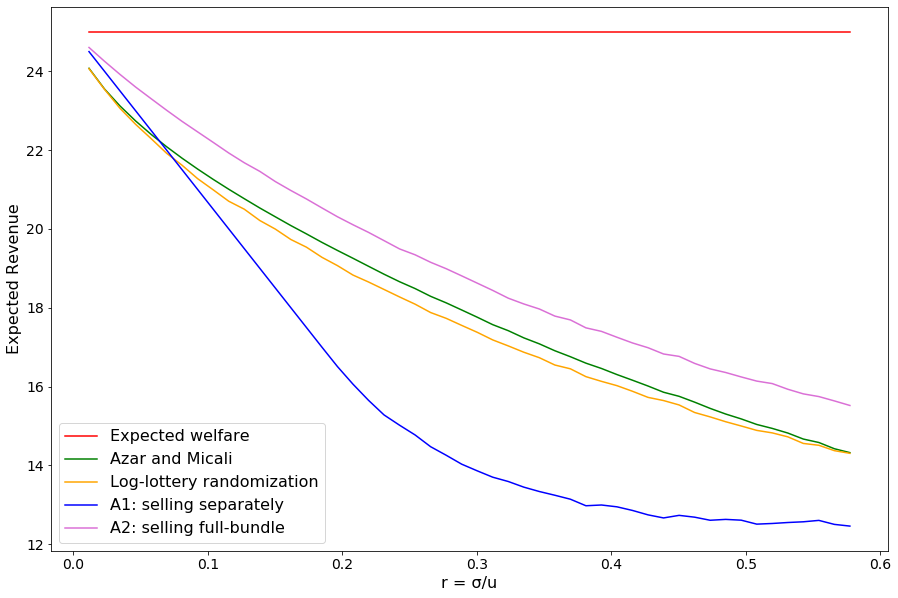

In [22]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='x', labelsize= 14)
plt.tick_params(axis='y', labelsize= 14)
#ax2.axhline(0,color="red")
plt.xlabel("r = \u03C3/u",fontsize=16)
plt.ylabel("Expected Revenue",fontsize=16)
# plt.axhline(u_m,color="red",label="Expected welfare")
plt.plot(r_list, u_m_list,color="red",label="Expected welfare")
plt.plot(r_list, rev_A_list,color="green",label="Azar and Micali")
plt.plot(r_list, APX_rev_list, color="#FFA500",label="Log-lottery randomization")
plt.plot(r_list, rev_A1_list,color="blue",label="A1: selling separately")
plt.plot(r_list, rev_A2_list, color="orchid",label="A2: selling full-bundle")

plt.legend(loc="best",fontsize = 16)
plt.savefig("MulU5m5_rev.png",bbox_inches='tight')

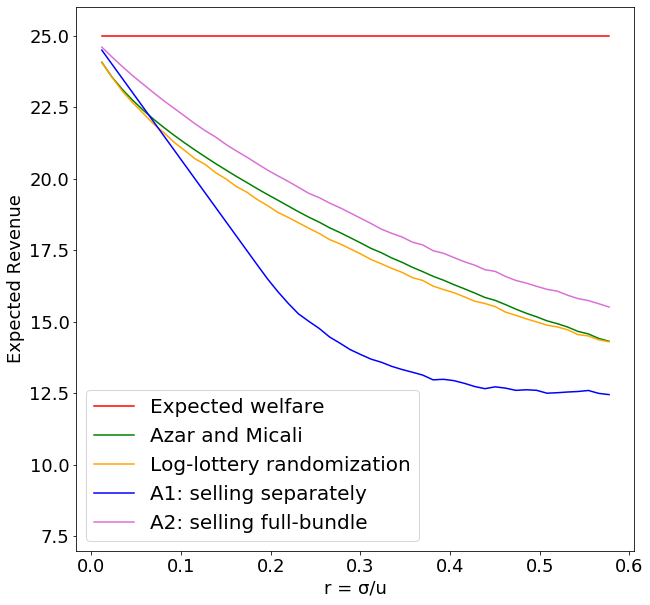

In [30]:
plt.figure(figsize=(10,10))
plt.tick_params(axis='x', labelsize= 18)
plt.tick_params(axis='y', labelsize= 18)
#ax2.axhline(0,color="red")
plt.xlabel("r = \u03C3/u",fontsize=18)
plt.ylabel("Expected Revenue",fontsize=18)
# plt.axhline(u_m,color="red",label="Expected welfare")
plt.plot(r_list, u_m_list,color="red",label="Expected welfare")
plt.plot(r_list, rev_A_list,color="green",label="Azar and Micali")
plt.plot(r_list, APX_rev_list, color="#FFA500",label="Log-lottery randomization")
plt.plot(r_list, rev_A1_list,color="blue",label="A1: selling separately")
plt.plot(r_list, rev_A2_list, color="orchid",label="A2: selling full-bundle")
plt.ylim(7,26)
plt.legend(loc="best",fontsize = 20)
plt.savefig("MulU5m5_rev_s.png",bbox_inches='tight')

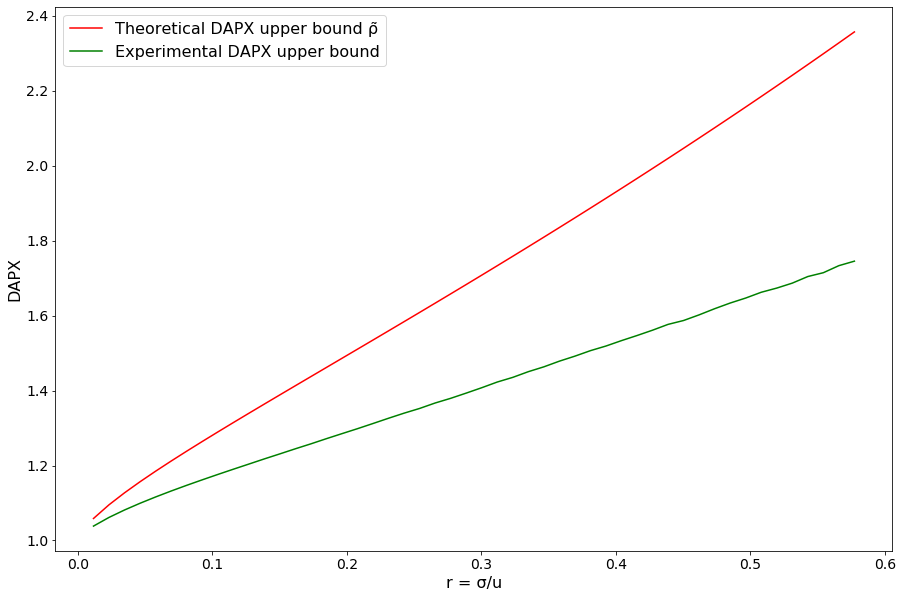

In [32]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='x', labelsize= 14)
plt.tick_params(axis='y', labelsize= 14)
#ax2.axhline(0,color="red")
plt.xlabel("r = \u03C3/u",fontsize=16)
plt.ylabel("DAPX",fontsize=16)
# plt.axhline(u_m,color="red",label="Expected welfare")
#plt.plot(r_list, rho_list, marker="o",color="red",label="Theoretical \u03C1\u0303")
plt.plot(r_list, rho_list, color="red",label="Theoretical DAPX upper bound \u03C1\u0303")
#plt.plot(r_list, r_rho_list, color="red",label="Theoretical APX upper bound \u03C1")
#plt.plot(r_list, APX_uniform_list, color="#FFA500",label="Experimental APX upper bound")
plt.plot(r_list, DAPX, color="green",label="Experimental DAPX upper bound")
#plt.plot(r_list, DAPX_A1,color="blue",label="A1: selling separately VS Azar and Micali")
#plt.plot(r_list, DAPX_A2, color="green",label="A2: selling full-bundle VS Azar and Micali")

plt.legend(loc="upper left",fontsize = 16)
plt.savefig("MulU5m5_dapx.png",bbox_inches='tight')

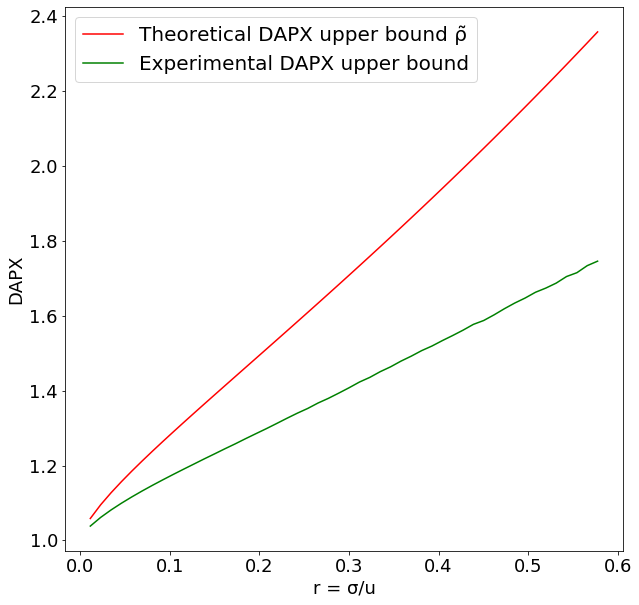

In [34]:
plt.figure(figsize=(10,10))
plt.tick_params(axis='x', labelsize= 18)
plt.tick_params(axis='y', labelsize= 18)
#ax2.axhline(0,color="red")
plt.xlabel("r = \u03C3/u",fontsize=18)
plt.ylabel("DAPX",fontsize=18)
# plt.axhline(u_m,color="red",label="Expected welfare")

plt.plot(r_list, rho_list, color="red",label="Theoretical DAPX upper bound \u03C1\u0303")

plt.plot(r_list, DAPX, color="green",label="Experimental DAPX upper bound")


plt.legend(loc="upper left",fontsize = 20)
plt.savefig("MulU5m5_dapx_s.png",bbox_inches='tight')

In [35]:
import pandas as pd 
  
# creating the DataFrame 
my_df = { 'r_list' : r_list,
          'u_m_list': u_m_list,
         'rev_A_list': rev_A_list,
         'APX_rev_list': APX_rev_list,
         'rev_A1_list': rev_A1_list,
         'rev_A2_list': rev_A2_list,
         'rho_list': rho_list,
         'DAPX': DAPX,
         'r_rho_list': r_rho_list,
         'APX_uniform_list': APX_uniform_list
         } 
df = pd.DataFrame(my_df) 
  
   
# saving the DataFrame as a CSV file 
gfg_csv_data = df.to_csv('U5m5.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data) 


CSV String:
 None


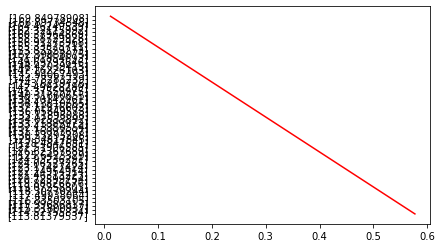

In [220]:
import pandas
test = pandas.read_csv('result_uniform17.csv')
plt.plot(test['r_list'],test['r_rho_list'], color="red",label="Theoretical APX upper bound \u03C1")

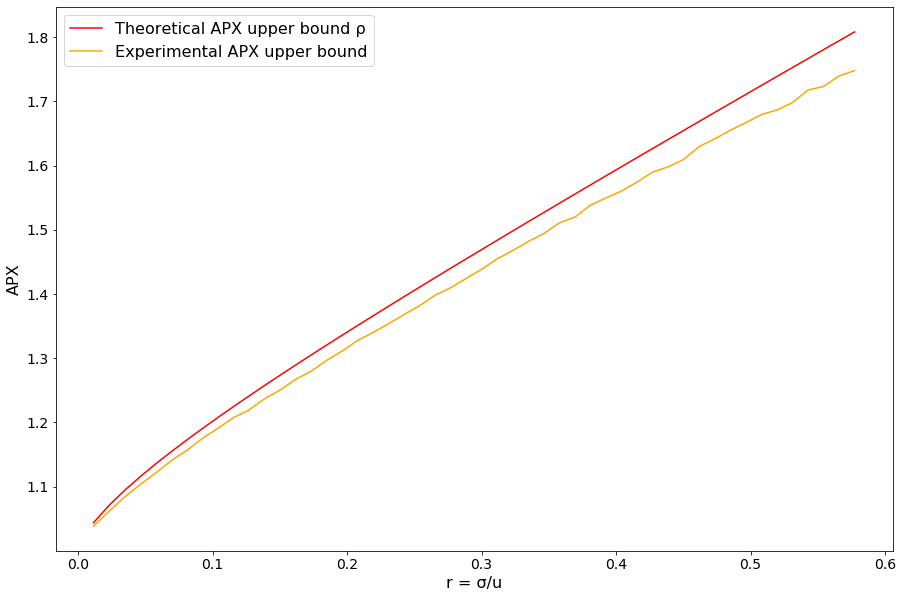

In [37]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='x', labelsize= 14)
plt.tick_params(axis='y', labelsize= 14)
#ax2.axhline(0,color="red")
plt.xlabel("r = \u03C3/u",fontsize=16)
plt.ylabel("APX",fontsize=16)
# plt.axhline(u_m,color="red",label="Expected welfare")

plt.plot(r_list, r_rho_list, color="red",label="Theoretical APX upper bound \u03C1")
plt.plot(r_list, APX_uniform_list, color="#FFA500",label="Experimental APX upper bound")


plt.legend(loc="upper left",fontsize = 16)

plt.savefig("MulU5m5_apx.png",bbox_inches='tight')

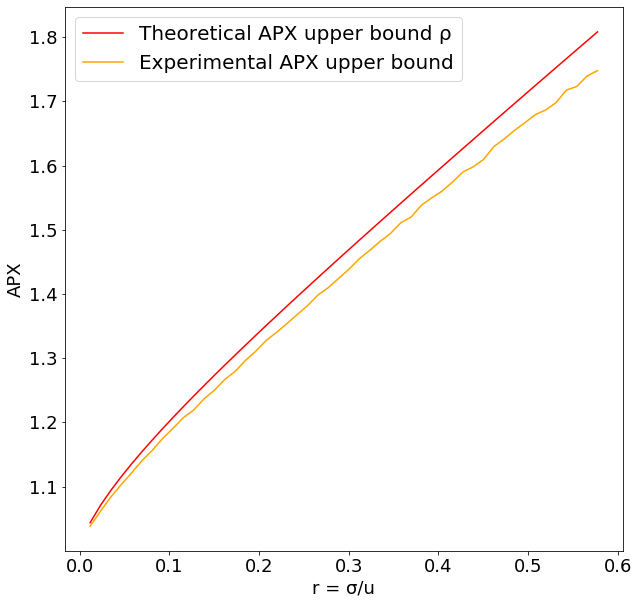

In [38]:
plt.figure(figsize=(10,10))
plt.tick_params(axis='x', labelsize= 18)
plt.tick_params(axis='y', labelsize= 18)
#ax2.axhline(0,color="red")
plt.xlabel("r = \u03C3/u",fontsize=18)
plt.ylabel("APX",fontsize=18)
# plt.axhline(u_m,color="red",label="Expected welfare")

plt.plot(r_list, r_rho_list, color="red",label="Theoretical APX upper bound \u03C1")
plt.plot(r_list, APX_uniform_list, color="#FFA500",label="Experimental APX upper bound")


plt.legend(loc="upper left",fontsize = 20)

plt.savefig("MulU5m5_apx_s.png",bbox_inches='tight')